In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [2]:
df = pd.read_csv("results_full.csv")

metric = "RMSE"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LinearRegressor', 'LogisticRegression' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer', 'TabPFNRegressor', 'GPBoost_RMSE'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LinearRegressor': 'Linear Regression',
    'TabPFNRegressor': 'TabPFN',
    'GPBoost_RMSE': 'GPBoost'
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

In [ ]:
outdir = os.path.join('PICTURES', metric.lower())
os.makedirs(outdir, exist_ok=True)

for split in splits:
    sub = df[df["split_method"] == split]
    if sub.empty:
        continue

    table = sub.pivot(
        index="model",
        columns="task_id",
        values="value"
    )

    baseline = table.min(axis=0)
    def third_largest(series: pd.Series) -> float:
        return series.dropna().nlargest(3).min()


    mid_err  = table.apply(third_largest, axis=0)

    norm_acc = (mid_err - table).div(mid_err - baseline, axis=1).clip(0, 1)

    summary = pd.DataFrame({
        "Mean": norm_acc.mean(axis=1),
        "Median": norm_acc.median(axis=1),
        "Std": norm_acc.std(axis=1)
    }).reset_index().rename(columns={"model": "Method"})

    summary["Method"] = pd.Categorical(
        summary["Method"],
        categories=method_order,
        ordered=True
    )
    summary = summary.sort_values("Method")
    summary["Method"] = summary["Method"].astype(str).map(rename_map).fillna(summary["Method"].astype(str))

    summary["Mean"] = 100 * summary["Mean"]

    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=summary, x="Method", y="Mean", color='black')
    plt.xlabel("Method")
    plt.ylabel("Average normalized accuracy (in %)")
    plt.title(f"Split: {split}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    fname = f"{split}_normalized_acc_{metric}.png"
    plt.savefig(os.path.join(outdir, fname), bbox_inches='tight')
    plt.show()




In [5]:
df = df[df["metric"] == "RMSE"]

df = df[df["split_method"] != "random_split"]


=== RAW normalized_accuracy sample ===
       split_method  task_id              model     value  baseline       mid  \
568      umap_split   361093    LinearRegressor  1.010513  0.467485  0.735538   
570      umap_split   361093  ConstantPredictor  1.188115  0.467485  0.735538   
572  kmedoids_split   361093    LinearRegressor  0.498135  0.066151  0.498135   
574  kmedoids_split   361093  ConstantPredictor  0.674505  0.066151  0.498135   
576     gower_split   361093    LinearRegressor  0.591701  0.066522  0.494303   
578     gower_split   361093  ConstantPredictor  0.723444  0.066522  0.494303   
583     gower_split   361093       GPBoost_RMSE  0.494303  0.066522  0.494303   
585  kmedoids_split   361093       GPBoost_RMSE  0.660671  0.066151  0.498135   
587      umap_split   361093       GPBoost_RMSE  0.735538  0.467485  0.735538   
596     gower_split   361093         Engression  0.079504  0.066522  0.494303   
598     gower_split   361093                MLP  0.100289  0.066522  

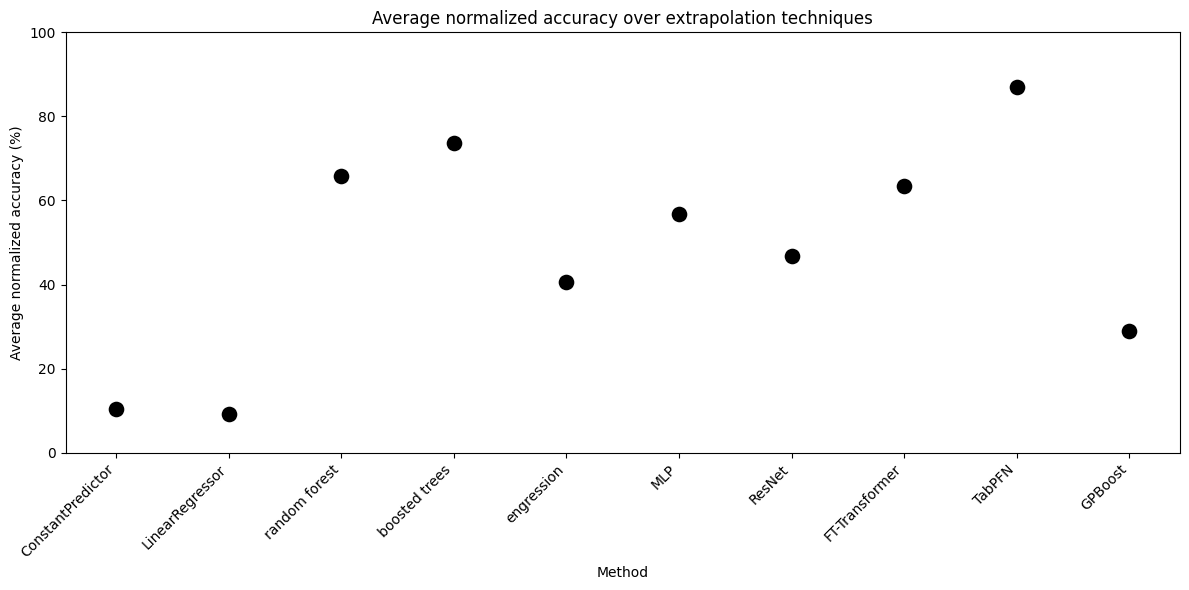

In [5]:
# helper to get the 3rd‐largest (or worst if <3)
def third_largest(s: pd.Series) -> float:
    vals = s.dropna().nlargest(3)
    return vals.min() if not vals.empty else np.nan

# 1) baseline (best = min error) per split & task
df["baseline"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform("min")
)

# 2) mid (3rd‐largest error) per split & task
df["mid"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform(third_largest)
)

# 3) normalized accuracy: (mid – err)/(mid – best), clipped into [0,1]
df["normalized_accuracy"] = (
    (df["mid"] - df["value"])
    / (df["mid"] - df["baseline"])
).clip(0, 1)

print("\n=== RAW normalized_accuracy sample ===")
print(df[['split_method','task_id','model','value','baseline','mid','normalized_accuracy']].head(20))

print("\n=== per-model normalized_accuracy summary ===")
print(
    df
    .groupby('model')["normalized_accuracy"]
    .agg(count='count', mean='mean', min='min', max='max')
    .sort_values('mean', ascending=False)
)

print("\n=== model appearance counts ===")
print(
    df
    .groupby('model')["normalized_accuracy"]
    .count()
    .sort_values(ascending=False)
)

overall = (
    df
    .groupby('model')["normalized_accuracy"]
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100   # to percent

method_order = [
    'ConstantPredictor','LinearRegressor',
    'RandomForestClassifier','RandomForestRegressor',
    'LGBMClassifier','LGBMRegressor','Engression',
    'MLP','ResNet','FTTransformer','TabPFNRegressor', 'GPBoost_RMSE'
]
overall = (
    overall
    .set_index('model')
    .reindex(method_order)
    .reset_index()
)
rename_map = {
    'RandomForestClassifier':'random forest',
    'RandomForestRegressor':'random forest',
    'LGBMClassifier':       'boosted trees',
    'LGBMRegressor':        'boosted trees',
    'Engression':           'engression',
    'MLP':                  'MLP',
    'ResNet':               'ResNet',
    'FTTransformer':        'FT-Transformer',
    'TabPFNRegressor':    'TabPFN',
    'GPBoost_RMSE':        'GPBoost'
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=overall,
    x='Method',
    y='Mean',
    color='black',
    s=150
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average normalized accuracy (%)')
plt.xlabel('Method')
plt.title('Average normalized accuracy over extrapolation techniques')
plt.ylim(0, 100)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
fname = f"PICTURES/avg_normalized_acc_over_extrapolation_{metric}.png"
plt.savefig(
    fname,
    bbox_inches='tight'
)
plt.show()


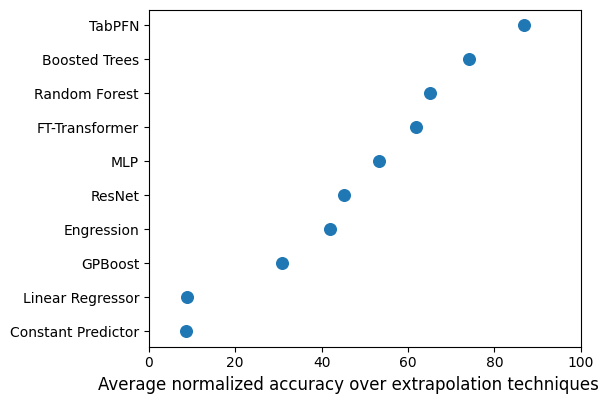

In [3]:
plt.rcParams.update({
    "figure.figsize": (6.2, 4.2),
    "font.size": 12, "axes.labelsize": 12, "axes.titlesize": 12,
    "xtick.labelsize": 10, "ytick.labelsize": 10
})

# 1) compute normalized accuracy (your logic, with a safer denominator)
def third_largest(s: pd.Series) -> float:
    vals = s.dropna().nlargest(3)
    return vals.min() if not vals.empty else np.nan

df["baseline"] = df.groupby(["split_method","task_id"])["value"].transform("min")
df["mid"]      = df.groupby(["split_method","task_id"])["value"].transform(third_largest)
den = (df["mid"] - df["baseline"]).replace(0, np.nan)
df["normalized_accuracy"] = ((df["mid"] - df["value"]) / den).clip(0, 1)

# 2) canonical display names (collapse classifier/regressor variants)
rename_map = {
    'RandomForestClassifier':'Random Forest',
    'RandomForestRegressor':'Random Forest',
    'LGBMClassifier':'Boosted Trees',
    'LGBMRegressor':'Boosted Trees',
    'Engression':'Engression',
    'MLP':'MLP',
    'ResNet':'ResNet',
    'FTTransformer':'FT-Transformer',
    'TabPFNRegressor':'TabPFN',
    'GPBoost_RMSE':'GPBoost',
    'LinearRegressor':'Linear Regressor',
    'ConstantPredictor':'Constant Predictor',
}
df["Method"] = df["model"].map(rename_map).fillna(df["model"])

stats = (df.groupby("Method")["normalized_accuracy"]
           .agg(mean="mean", std="std", count="count"))
stats["se"] = stats["std"] / np.sqrt(stats["count"]).replace(0, np.nan)
stats = (stats.sort_values("mean", ascending=False) * 100)  # percent

ypos = np.arange(len(stats))
fig, ax = plt.subplots()
ax.scatter(stats["mean"].values, ypos, s=70)
#ax.errorbar(stats["mean"].values, ypos, xerr=None, fmt="o", ms=6, capsize=3, ls="none")
ax.set_yticks(ypos)
ax.set_yticklabels(stats.index)
ax.invert_yaxis()  # best at top
ax.set_xlabel("Average normalized accuracy over extrapolation techniques (%)")
ax.set_ylabel("")
plt.xlim(0, 100)
ax.grid(False)
plt.tight_layout()

# 5) vector export (crisp in LaTeX)
import os
os.makedirs("PICTURES", exist_ok=True)
plt.savefig("PICTURES/avg_normalized_acc_over_extrapolation_RMSE.pdf", bbox_inches="tight")
plt.show()
plt.close()
